In [14]:
import csv 
import numpy as np
import pandas as pd
import sys
import platform
system = platform.system()
if system =='Linux':
    sys.path.append('/home/lucas/Documents/Log_Analysis/Battery')
elif system =='Darwin':
    sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis')
from battery import OCVcurve, Thevenin
import analog
from scipy.interpolate import interp1d as interp1d
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

In [15]:
path2curve = 'Battery 9 (RIP)/Discharge 200mA/SOCvsOCV_discharge200mA.csv'
curve = OCVcurve(path2curve)

Polynomial coefficients are [ 1.54079666e+04 -8.79957879e+04  2.19186396e+05 -3.12687981e+05
  2.82109975e+05 -1.67743633e+05  6.64413360e+04 -1.73142475e+04
  2.86290965e+03 -2.80825943e+02  1.48923600e+01  3.33948616e+00]


### Import the test file

In [16]:
if system == 'Linux':
    folder = '/home/lucas/Documents/Log_Analysis/Logs/KF Testing/Donald Trump/Both'
elif system == 'Darwin':
    folder = '/Users/Lucas/Documents/Travail/Yuneec/Logs/KF Testing/H3/Both'
    
log_file = analog.pathfromQGC(folder,index=173)

print(log_file)
info = analog.logextract(log_file,['battery_status','battery_status_ekf','vehicle_local_position'])
print(info.keys())

# From battery_status
current = info['battery_current']
current_filtered = info['battery_filtered_current']
SOC = info['remaining']
time = info['time_bs']
time_ekf = info['time_bkf']
n_cells = info['n_cells']
voltage = info['battery_voltage']/n_cells
# From battery_status_ekf
voltage_ekf = info['voltage_ekf']/n_cells[:-1]
voltage_estimate = info['voltage_estimate']
SOC_ekf = info['remaining_ekf']
kalman_gain = info['kalman_gain']
kalman_gain = np.squeeze(kalman_gain)
covar_x = info['covx']
covar_w = info['covw']
innovation = info['innovation']
iR1 = info['iR1']

# discard timestamps with non-initalized battery
current = current[voltage>0]
current_filtered = current_filtered[voltage>0]
SOC = SOC[voltage>0]
time = time[voltage>0]
# kalman_gain = kalman_gain[:,voltage>0]
# covar_x = covar_x[:,:,voltage>0]
# innovation = innovation[voltage>0]
# iR1 = iR1[voltage>0]
voltage = voltage[voltage>0] # to be done at the end
print(len(time))

# # From vehicle_local_position
# x = info['x']
# y = info['y']
# z = info['z']
# time_vlp = info['time_vlp']

/home/lucas/Documents/Log_Analysis/Logs/KF Testing/Donald Trump/Both/log_173_2019-12-19-10-15-02.ulg
dict_keys(['time_vlp', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'time_bkf', 'remaining_ekf', 'voltage_estimate', 'covx', 'covw', 'kalman_gain', 'innovation', 'iR1', 'voltage_ekf', 'time_bs', 'n_cells', 'battery_current', 'battery_filtered_current', 'battery_voltage', 'battery_filtered_voltage', 'discharged_mah', 'remaining'])
17085


# Kalman filter analysis

<IPython.core.display.Javascript object>


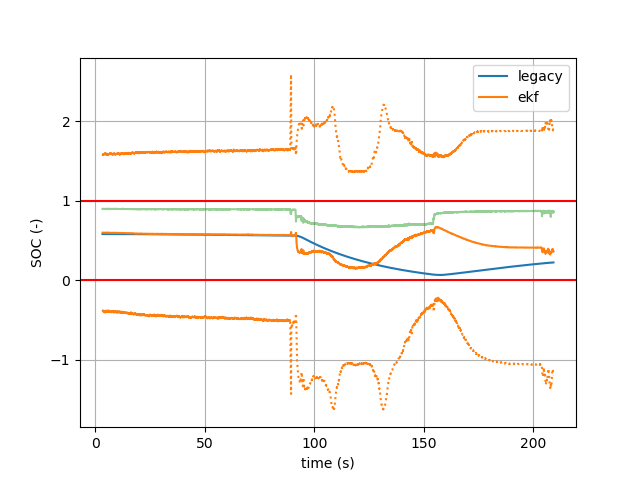

In [17]:
%matplotlib notebook
plt.figure()
plt.plot(time,SOC,label='legacy')
plt.plot(time_ekf,SOC_ekf,label='ekf')
plt.plot(time_ekf,SOC_ekf + 3*np.sqrt(covar_x[0,0,:]),linestyle=':',color='C1')
plt.plot(time_ekf,SOC_ekf - 3*np.sqrt(covar_x[0,0,:]),linestyle=':',color='C1')
plt.plot(time,voltage/4.35,alpha=0.5)
plt.xlabel('time (s)')
plt.ylabel('SOC (-)')
plt.axhline(0,color='r')
plt.axhline(1,color='r')
#plt.plot(time,current/current[0],alpha=.7)
plt.grid()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


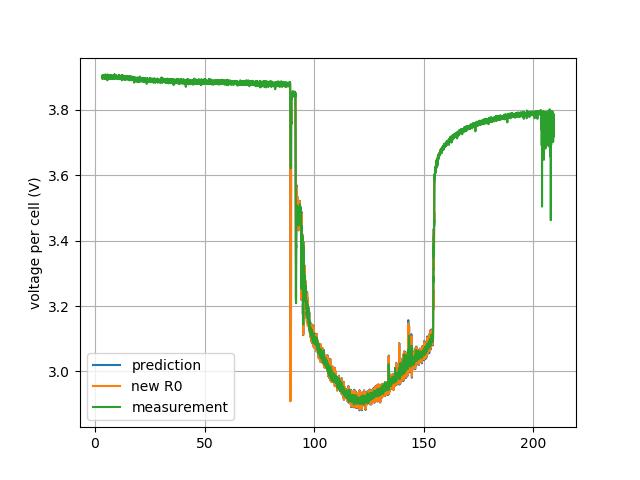

In [22]:
%matplotlib notebook
voltage_R0 = curve.OCVfromSOC(SOC_ekf) - 0.01*iR1 - 0.012*current[:-1]
plt.figure()
plt.plot(time_ekf,voltage_estimate,label='prediction')
plt.plot(time_ekf,voltage_R0,label='new R0')
plt.plot(time_ekf,voltage[:-1],label='measurement')
#plt.plot(time_ekf, yhat_SOC,label='SOC')
#plt.plot(time_ekf,yhat_inno,LineStyle=':',label='inno')
#plt.plot(time,voltage)
plt.ylabel('voltage per cell (V)')
plt.legend()
plt.grid()

<IPython.core.display.Javascript object>


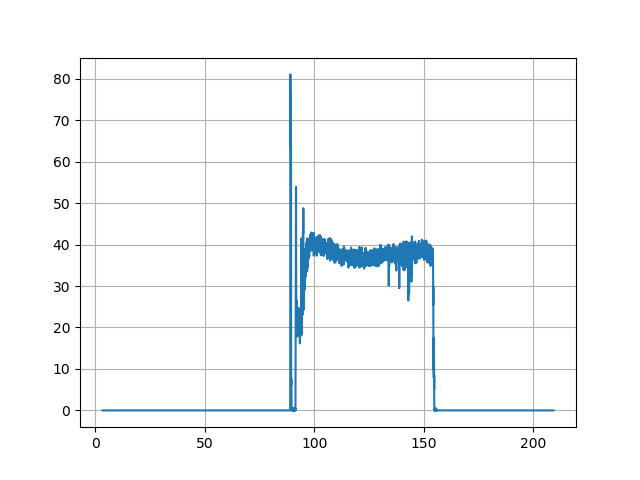

In [18]:
plt.figure()
plt.plot(time, current)
plt.grid()

# Simulation


In [19]:
ECparams = pd.read_csv('ECparams.csv')
R0 = float(ECparams['R0'])
R0 = 0.015
R1 = float(ECparams['R1'])
R1 = 0.01
C1 = float(ECparams['C1'])
C1 = 700 
print([R0,R1,C1])

[0.015, 0.01, 700]


### Tune some more simulation parameters

In [20]:
Q = 6500*3.6 # has to be in Coulombs
eta = 1
z0 = SOC_ekf[0]
print(f'z0 = {z0}')
battery = Thevenin(z0,Q,curve,R0,R1,C1)

z0 = 0.5983168482780457


### Run the simulation using the state-space model

In [21]:
xhat0 = np.array([[SOC[0]],[iR1[0]]]) # is a stack of 2x1 arrays = a 2xk array
covx0 = covar_x[:,:,0]
print(f'covx0 = {covx0}')
covx0 = np.array([[0.1,0.],[0., 0.01]]) # is a stack of 2x2 arrays

covw = np.array([[1e-4, 0.],[0., 1e-5]]) # is a constant 2x2 array
#covw = covar_w[:,:,0]
print(f' covw = {covw}')
step=1
u = current[slice(1,len(current),step)] # is a stack of 1x1 arrays = a 1-D array
y = voltage[slice(1,len(voltage),step)] # is a stack of 1x1 arrays = a 1-D array

kfbat = Thevenin(z0,Q,curve,R0,R1,C1)

covx0 = [[0.10799953 0.01748072]
 [0.01748072 1.6396542 ]]
 covw = [[1.e-04 0.e+00]
 [0.e+00 1.e-05]]


In [22]:
xhat,covx,yhat,L = kfbat.kfrun(time_ekf,u,y,covw=covw,covx0=covx0,alpha=0.9)

## Comparison of Kalman filter results with firmware ones

<IPython.core.display.Javascript object>


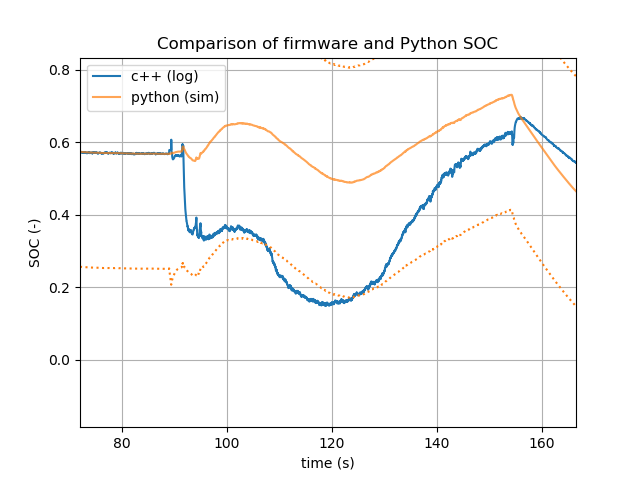

In [23]:
n=len(time)
plt.figure()
plt.plot(time_ekf,SOC_ekf,label='c++ (log)')
plt.plot(time_ekf,SOC_ekf+3*np.sqrt(covar_x[0,0,:]),linestyle=':',color='C0')
plt.plot(time_ekf,SOC_ekf-3*np.sqrt(covar_x[0,0,:]),linestyle=':',color='C0')
plt.plot(time[slice(0,n-1,step)],xhat[0,:],alpha=0.7,label='python (sim)')
plt.plot(time[slice(0,n-1,step)],xhat[0,:]+3*np.sqrt(covx[0,0,:]),linestyle=':',color='C1')
plt.plot(time[slice(0,n-1,step)],xhat[0,:]-3*np.sqrt(covx[0,0,:]),linestyle=':',color='C1')
plt.xlabel('time (s)')
plt.ylabel('SOC (-)')
plt.legend()
plt.grid()
plt.title('Comparison of firmware and Python SOC')
plt.show()

In [75]:
print(xhat[0,0])
print(np.max(xhat[0,:]))
print(f'Err max : {np.max(xhat[0,:]) - xhat[0,0]}')

0.5983168482780457
0.6041210523272695
Err max : 0.005804204049223882


In [71]:
print(np.min(xhat[0,:]))
print(xhat[0,-1])
print(f'Err min : {xhat[0,0] - np.min(xhat[0,:])}')

0.046524355970441744
0.3568776495773832
Err min : 0.5517924923076039


When downsampling the current and the voltage measurements, the steepness of the rise to the correct/likely value of SOC is lower. I think that is due to the limit on innovation.

<IPython.core.display.Javascript object>


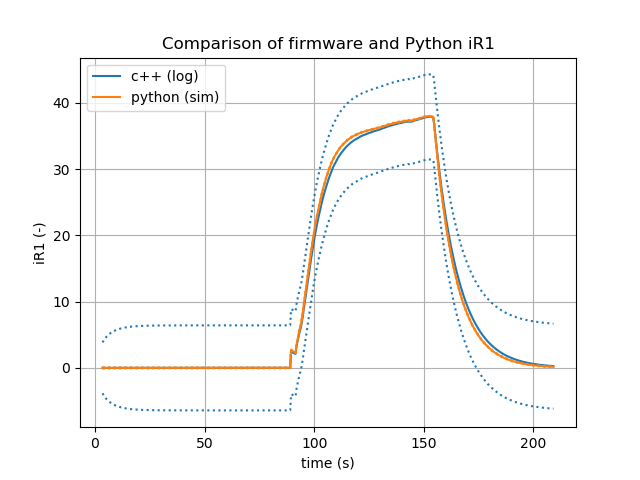

In [33]:
plt.figure()
plt.plot(time_ekf,iR1,label='c++ (log)')
plt.plot(time_ekf,iR1+3*np.sqrt(covar_x[1,1,:]),linestyle=':',color='C0')
plt.plot(time_ekf,iR1-3*np.sqrt(covar_x[1,1,:]),linestyle=':',color='C0')
plt.plot(time_ekf[slice(0,n-1,step)],xhat[1,:],label='python (sim)')
plt.plot(time_ekf[slice(0,n-1,step)],xhat[1,:]+np.sqrt(covx[1,1,:]),linestyle=':',color='C1')
plt.plot(time_ekf[slice(0,n-1,step)],xhat[1,:]-np.sqrt(covx[1,1,:]),linestyle=':',color='C1')
plt.xlabel('time (s)')
plt.ylabel('iR1 (-)')
plt.legend()
plt.title('Comparison of firmware and Python iR1')
plt.grid()

<IPython.core.display.Javascript object>


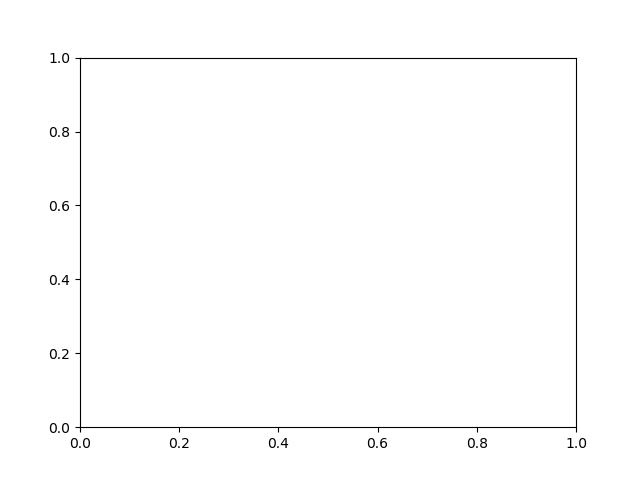

ValueError: x and y must have same first dimension, but have shapes (17083,) and (17084,)

In [34]:
plt.figure()
plt.plot(time_ekf[slice(1,n,step)],covx[1,1,:])
plt.grid()
print(min(covx[1,1,:]))

In [ ]:
plt.figure()
plt.plot(time,innovation,label='c++ (log)')
plt.plot(time[slice(1,n,step)],y-yhat,label='python (sim)')
plt.xlabel('time (s)')
plt.ylabel('innovation (-)')
plt.legend()
plt.grid()
plt.title('Comparison of firmware and Python innovation')

In [ ]:
plt.figure()
plt.subplot(211)
plt.plot(time,kalman_gain[0,:],label='c++ (log)')
plt.plot(time[slice(1,n,step)],L[0,:],label='python (sim)')
plt.grid()
plt.ylabel('K0 (-)')
plt.title('Comparison of firmware and Python Kalman Gain')
plt.subplot(212)
plt.plot(time,kalman_gain[1,:],label='c++ (log)')
plt.plot(time[slice(1,n,step)],L[1,:],label='python (sim)')
plt.xlabel('time (s)')
plt.ylabel('K1 (-)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure()
plt.plot(time_ekf[slice(1,n,step)],L[0,:]*(y-yhat))
plt.grid()

In [ ]:
covy = kfbat.C@kfbat.covx@kfbat.C.T + kfbat.covv
plt.figure()
plt.plot(time_ekf[slice(1,n,step)],np.squeeze((y-yhat)*1/covy*(y-yhat)))
plt.axhline(kfbat.chisquare,color='r')
plt.grid()
print(kfbat.chisquare)